In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support as scores
from statistics import variance
import matplotlib.pyplot as plt

import psycopg2
import pandas.io.sql as sqlio
import psycopg2.extras


In [2]:
# Establish a connection to the PLUTO database
try:
    conn = psycopg2.connect("dbname='pluto' user='oliver' host='localhost' password='m'")
except:
    print("I am unable to connect to the database")

# Create a cursor object for executing queries
conn.autocommit = True
cur = conn.cursor()

In [3]:
    cov = [
    'xcoord'
    ,'ycoord'
    ,'age'
    ,'build_alter_gap'
    ,'alterage'      
    ,'elevator'
    ,'commercial'
    ,'garage'
    ,'storage'
    ,'basement'
    ,'waterfront'
    ,'frontage'
    ,'block_assmeblage'
    ,'cooperative'
    ,'conv_loft_wh'
    ,'tenament'
    ,'garden'
    ,'semi_fireproof'
    ,'fireproof'
    ,'luxury'
    ,'artist_res'
    ,'units_per_building'
    ,'floors'
    ,'zip_avg_num_buildings'
    ,'pcvpu_l1'
    ,'pcvpu_l2'
    ,'pcvpu_l3'
    ,'avg_block_pcvpu_l1'
    ,'avg_block_pcvpu_l2'
    ,'avg_block_pcvpu_l3'
    ,'avg_neighbor1_pcvpu_l1'
    ,'avg_neighbor1_pcvpu_l2'
    ,'avg_neighbor1_pcvpu_l3'
    ,'avg_neighbor2_pcvpu_l1'
    ,'avg_neighbor2_pcvpu_l2'
    ,'avg_neighbor2_pcvpu_l3'
    ,'avg_neighbor3_pcvpu_l1'
    ,'avg_neighbor3_pcvpu_l2'
    ,'avg_neighbor3_pcvpu_l3'
    ,'avg_neighbor4_pcvpu_l1'
    ,'avg_neighbor4_pcvpu_l2'
    ,'avg_neighbor4_pcvpu_l3'
    ,'avg_zip_pcvpu_l1'
    ,'avg_zip_pcvpu_l2'
    ,'avg_zip_pcvpu_l3'
    ]

In [4]:
# Commands to select data from each year
sql_2008 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2008
         """
sql_2009 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2009
         """
sql_2010 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2010
         """
sql_2010 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2010
         """
sql_2011 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2011
         """
sql_2012 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2012
         """
sql_2013 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2013
         """
sql_2014 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2014
         """
sql_2015 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2015
         """
sql_2016 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2016
         """
sql_2017 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2017
         """
sql_2018 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2018
         """
sql_2019 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2019
         """
sql_2020 = """SELECT * 
         FROM pluto_sym
         WHERE year = 2020
         """

In [5]:
# Function for creating dataframes from a SQL query
def get_data(sql_train, sql_test, cov):
    """
    Function to return data from a train and test SQL query
    """
    global df_train, df_test, X_train, X_test, y_train, y_test, covariates

    # List of columns to be used as covariates in the model

    df_train = sqlio.read_sql_query(sql_train, conn).dropna()
    df_test = sqlio.read_sql_query(sql_test, conn).dropna()

    covariates = df_train.columns.intersection(cov)

    X_train = df_train[covariates]
    y_train = df_train['pcvpu_target']

    X_test = df_test[covariates]
    y_test = df_test['pcvpu_target']
    return df_train, df_test, X_train, X_test, y_train, y_test

In [6]:
# Create a random forest classifier object
# warm_start = True allows the model to be trained on new data without having to retrain the entire model
gbr = XGBRegressor(n_estimators=100, max_depth=5, eta=0.03, random_state=0)

In [7]:
# Set up empty lists to store the results of the model for each year

MAEs = [] ## Mean Absolute Error, list of numbers (out of sample)
MSEs = [] ## Mean Squared Error, list of numbers (out of sample)
R2s = []  ## R2 score, list of numbers (out of sample)

feature_importances = [] ## Feature importances, list of lists

MAEs_in_sample = [] ## Mean Absolute Error, list of numbers (in sample)
MSEs_in_sample = [] ## Mean Squared Error, list of numbers (in sample)
R2s_in_sample = []  ## R2 score, list of numbers (in sample)


def update_reports():
    """
    Function to update the reports for each year
    """
    print('Updating Out of Sample Reports')

    MSEs.append(mean_squared_error(y_test, y_pred))
    MAEs.append(mean_absolute_error(y_test, y_pred))
    R2s.append(r2_score(y_test, y_pred))
    print('MSE: {}'.format(MSEs[-1]))
    print('MAE: {}'.format(MAEs[-1]))
    print('R2: {}'.format(R2s[-1]))

    print('Updating In Sample Reports')

    MSEs_in_sample.append(mean_squared_error(y_train, y_pred_in_sample))
    MAEs_in_sample.append(mean_absolute_error(y_train, y_pred_in_sample))
    R2s_in_sample.append(r2_score(y_train, y_pred_in_sample))
    print('MSE: {}'.format(MSEs_in_sample[-1]))
    print('MAE: {}'.format(MAEs_in_sample[-1]))
    print('R2: {}'.format(R2s_in_sample[-1]))

    print('Updating Feature Importances')
    feature_importances.append(pd.Series(gbr.feature_importances_, index=cov))


In [8]:
# get data from 2008 and 2009
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2008, sql_2009, cov)


In [9]:
# fit the model for 2008 and 2009
gbr.fit(X_train,y_train)
gbr.save_model('pluto-10-03-2a--y2008-2009.model')

In [10]:
# Make in and out of sample predictions
y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)

In [11]:
# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 299.86273398878944
MAE: 5.613833663426687
R2: 0.06692967005016426
Updating In Sample Reports
MSE: 334.4652942667681
MAE: 5.894350789034517
R2: 0.30357771277207024
Updating Feature Importances


In [12]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2009, sql_2010, cov)

In [13]:
# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2008-2009.model')
gbr.save_model('pluto-10-03-2a--y2009-2010.model')

In [14]:
y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)

In [15]:
# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 207.36264146529788
MAE: 5.8141650987074724
R2: -0.03203513512077061
Updating In Sample Reports
MSE: 263.7312712593215
MAE: 5.200580212969522
R2: 0.1793584317108754
Updating Feature Importances


In [16]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2010, sql_2011, cov)

# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2009-2010.model')
gbr.save_model('pluto-10-03-2a--y2010-2011.model')

y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)

# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 40.95903740559834
MAE: 3.414515131608674
R2: -0.4125058591846429
Updating In Sample Reports
MSE: 172.81679542220456
MAE: 4.971982724325988
R2: 0.1398980860082223
Updating Feature Importances


In [17]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2011, sql_2012, cov)

# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2010-2011.model')
gbr.save_model('pluto-10-03-2a--y2011-2012.model')

y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)

# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 141.23122610709595
MAE: 5.654396953429164
R2: -0.04655318233228045
Updating In Sample Reports
MSE: 28.32925234342778
MAE: 2.0734472113346114
R2: 0.023042594356900592
Updating Feature Importances


In [18]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2012, sql_2013, cov)

# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2011-2012.model')
gbr.save_model('pluto-10-03-2a--y2012-2013.model')

y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)

# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 143.43525749845284
MAE: 5.078596940091264
R2: -0.06120280380795773
Updating In Sample Reports
MSE: 99.51711222917692
MAE: 3.6876228476313937
R2: 0.26255720232162616
Updating Feature Importances


In [19]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2013, sql_2014, cov)
# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train , xgb_model='pluto-10-03-2a--y2012-2013.model')
gbr.save_model('pluto-10-03-2a--y2013-2014.model')
# make predictions for the next year
y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 107.18521625527752
MAE: 4.329139368805698
R2: -0.043097773227722014
Updating In Sample Reports
MSE: 113.66103564289688
MAE: 4.33628407561056
R2: 0.15908116448105925
Updating Feature Importances


In [20]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2014, sql_2015, cov)
# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2013-2014.model')
gbr.save_model('pluto-10-03-2a--y2014-2015.model')
# make predictions for the next year
y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 121.82616539940102
MAE: 4.358073728575566
R2: 0.04916268644390165
Updating In Sample Reports
MSE: 89.38590186453406
MAE: 3.5944529187450187
R2: 0.1301203799338666
Updating Feature Importances


In [21]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2015, sql_2016, cov)
# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2014-2015.model')
gbr.save_model('pluto-10-03-2a--y2015-2016.model')
# make predictions for the next year
y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 92.72066316929018
MAE: 3.6843447141495087
R2: 0.009166195393036869
Updating In Sample Reports
MSE: 110.57585523377516
MAE: 4.093376835491773
R2: 0.13696988828339385
Updating Feature Importances


In [22]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2016, sql_2017, cov)
# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2015-2016.model')
gbr.save_model('pluto-10-03-2a--y2016-2017.model')
# make predictions for the next year
y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 108.4083498537541
MAE: 3.5416438729363007
R2: 0.027948958583053796
Updating In Sample Reports
MSE: 86.04072276071916
MAE: 3.407118521230296
R2: 0.08054953696262546
Updating Feature Importances


In [23]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2017, sql_2018, cov)
# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2016-2017.model')
gbr.save_model('pluto-10-03-2a--y2017-2018.model')
# make predictions for the next year
y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 8966.01383996865
MAE: 76.00761015811557
R2: -0.021658262489478997
Updating In Sample Reports
MSE: 103.32806160047264
MAE: 3.4242489344067377
R2: 0.07350171807032968
Updating Feature Importances


In [24]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2018, sql_2019, cov)
# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2017-2018.model')
gbr.save_model('pluto-10-03-2a--y2018-2019.model')
# make predictions for the next year
y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 3058.0800289928557
MAE: 45.26577348707785
R2: -15.121769772445997
Updating In Sample Reports
MSE: 2284.3554479600475
MAE: 31.79765809078609
R2: 0.7397025412265705
Updating Feature Importances


In [25]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2019, sql_2020, cov)
# expand the number of trees and then fit to the next year
gbr.fit(X_train,y_train, xgb_model='pluto-10-03-2a--y2018-2019.model')
gbr.save_model('pluto-10-03-2a--y2019-2020.model')
# make predictions for the next year
y_pred = gbr.predict(X_test)
y_pred_in_sample = gbr.predict(X_train)
# update all the report series
update_reports()

Updating Out of Sample Reports
MSE: 764.991717266354
MAE: 21.213028144246202
R2: -3.828158145463437
Updating In Sample Reports
MSE: 498.8616220703156
MAE: 16.04721934984837
R2: -1.6299286294267814
Updating Feature Importances


Text(0.5, 1.0, 'R2 Score by Year')

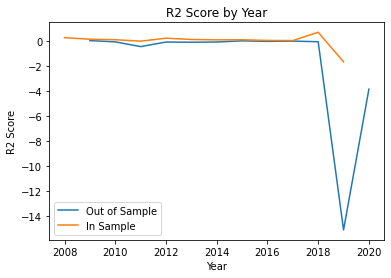

In [28]:
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
years_in_sample = [2008 ,2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
plt.plot(years, R2s, label='Out of Sample')
plt.plot(years_in_sample, R2s_in_sample, label='In Sample')
plt.legend()
plt.xlabel('Year')
plt.ylabel('R2 Score')
plt.title('R2 Score by Year')

Text(0.5, 1.0, 'Mean Squared Error by Year')

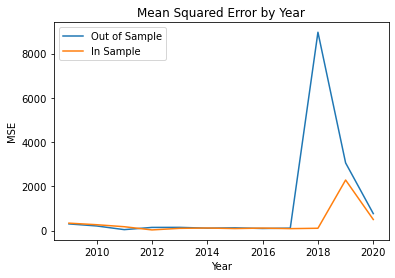

In [29]:
plt.plot(years, MSEs, label='Out of Sample')
plt.plot(years_in_sample, MSEs_in_sample, label='In Sample')
plt.legend()
plt.xlabel('Year')
plt.ylabel('MSE')
plt.title('Mean Squared Error by Year')

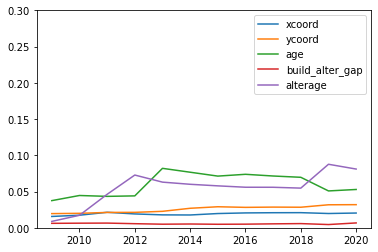

In [ ]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][0:5] for i in range(len(feature_importances))])
plt.legend(cov[0:5])

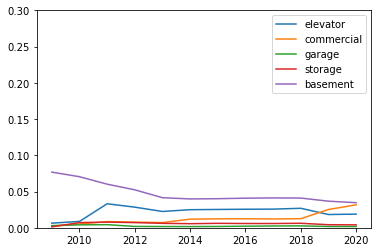

In [ ]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][5:10] for i in range(len(feature_importances))])
plt.legend(cov[5:10])

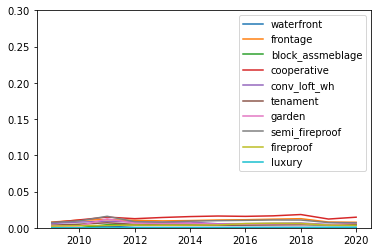

In [ ]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][10:20] for i in range(len(feature_importances))])
plt.legend(cov[10:20])

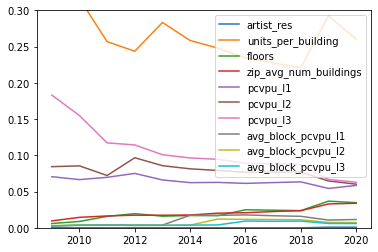

In [ ]:
plt.axis([None, None, 0, 0.3])

plt.plot(years, [feature_importances[i][20:30] for i in range(len(feature_importances))])
plt.legend(cov[20:30])

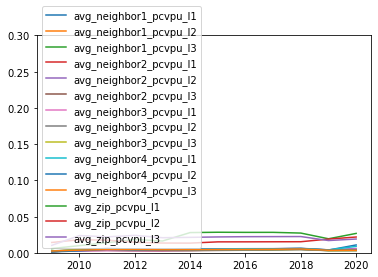

In [ ]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][30:] for i in range(len(feature_importances))])
plt.legend(cov[30:])